# 서울시 주요 공원현황 자료 분석및 비교

In [1676]:
import time
import pandas as pd
import numpy as np
import re
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
from tqdm import tqdm_notebook
from glob import glob
import seaborn as sns
import json
import folium
import warnings
import requests
from urllib.parse import urlparse, quote
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import googlemaps
warnings.simplefilter(action='ignore',category=FutureWarning)
%matplotlib inline
mpl.rc('font', family='Malgun Gothic')
mpl.rc('axes', unicode_minus=False)

## 데이터 정리

In [1677]:
park = pd.read_csv('./data/서울시 주요 공원현황.csv',encoding='euc-kr')
park.head()
park2 = park[['공원명','면적','지역','공원주소','X좌표(WGS84)','Y좌표(WGS84)']]


### 면적부분이 복잡해서 숫자만 뽑아냈습니다

In [1678]:
park2[park2['지역']=='강서구']

,공원명,면적,지역,공원주소,X좌표(WGS84),Y좌표(WGS84)
9,매화근린공원,1980.4㎡,강서구,서울특별시 강서구 등촌동 630-14,126.86,37.56
33,허준공원,29843.8㎡,강서구,서울특별시 강서구 허준로5길 42,126.85,37.57
35,궁산근린공원,135002.7㎡,강서구,서울특별시 강서구 가양동 산4-7,126.84,37.57
37,꿩고개근린공원,180000㎥,강서구,서울특별시 강서구 방화동 산110,126.82,37.58
53,방화근린공원,72132㎡,강서구,서울특별시 강서구 금낭화로 176(방화공원),126.81,37.58
57,염창근린공원,112070㎡,강서구,서울특별시 강서구 염창동 산24-1,126.87,37.56
76,우장산근린공원,359435.2㎡,강서구,서울특별시 강서구 내발산동 산4-5,126.84,37.55
88,봉제산공원,917190㎡,강서구,서울특별시 강서구 화곡동 산41-6,126.85,37.54
112,개화근린공원,386500㎡,강서구,서울특별시 강서구 개화동 산17,126.81,37.58


In [1679]:
park2[['면적']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   면적      129 non-null    object
dtypes: object(1)
memory usage: 1.2+ KB


In [1680]:
park_size = []
for i in park2['면적']:
    if type(i) == str:
        if i.split()[0] == '총':
            park_size.append(i.split()[1])
        elif i.split()[0] == '휴양':
            park_size.append('')
        else:
            park_size.append(i.split()[0])
    else:
        print(i)
        park_size.append(i)
park_size2 = []
for i in park_size:
    k = [float(a) for a in re.findall(r"[-+]?\d*\.\d+|\d+", str(i))]
    if not k:
        k = np.nan
    else:
        k = k[0]
    # print(k)
    try:
        # print(k)
        park_size2.extend(k)
    except:
        park_size2.append(k)
len(park_size2),len(park_size)


nan
nan
nan


(132, 132)

In [1681]:
pd.options.display.float_format = '{:.2f}'.format # 지수형을 실수형으로
park2['면적'] = park_size2
park2.sort_values(by='면적').tail()

,공원명,면적,지역,공원주소,X좌표(WGS84),Y좌표(WGS84)
23,관악산도시자연공원,10420819.08,관악구,서울특별시 관악구 관악로 1(관악산공원),126.96,37.45
6,진관근린공원(구파발폭포),nan,은평구,서울특별시 은평구 진관동 393,126.92,37.64
109,푸른수목원,nan,구로구,서울특별시 구로구 연동로 240(항동81-1) 푸른수목원관리사무소,126.82,37.48
119,문화역 서울284,nan,중구,서울특별시 중구 통일로 1 서울역,126.97,37.56
131,서울로7017,nan,중구,서울로7017,nan,nan


In [1682]:
park2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   공원명         132 non-null    object 
 1   면적          128 non-null    float64
 2   지역          131 non-null    object 
 3   공원주소        132 non-null    object 
 4   X좌표(WGS84)  131 non-null    float64
 5   Y좌표(WGS84)  131 non-null    float64
dtypes: float64(3), object(3)
memory usage: 6.3+ KB


### 혹시 몰라서 구주소도 넣었습니다

In [1683]:
key_fd = open('./data/kmap_key.txt')
kmap_key = key_fd.read(100)
key_fd.close()
old_addr = []
park_lng = []
park_lat = []
error_list = ['봉제산공원','개화근린공원']
for i in park2.index:
    try:
        url = 'https://dapi.kakao.com/v2/local/search/keyword.json?query=' + park2['공원명'][i] 
        result = requests.get(urlparse(url).geturl(), headers={"Authorization":"KakaoAK "+ kmap_key}).json()
        address = result['documents'][0]['address_name']
        # 봉제산공원은 키워드로 검색하면 다른데로 나와서 주소로 검색하게 예외를 발생시켰습니다
        if park2['공원명'][i] in error_list:
            raise Exception('오류발생')
        # if park2['공원명'][i] == :
        #     raise Exception('오류발생')
        lat = result['documents'][0]['x']
        lng = result['documents'][0]['y']
        old_addr.append(address)
        park_lat.append(lat)
        park_lng.append(lng)
    except:
        # print(park2['공원명'][i])
        try:
            url = 'https://dapi.kakao.com/v2/local/search/address.json?query=' + park2['공원주소'][i] 
            result = requests.get(urlparse(url).geturl(), headers={"Authorization":"KakaoAK "+ kmap_key}).json()
            address = result['documents'][0]['address']['address_name']
            lat = result['documents'][0]['address']['x']
            lng = result['documents'][0]['address']['y']
            old_addr.append(address)
            park_lat.append(lat)
            park_lng.append(lng)
            print('주소로 검색',park2['공원명'][i])
        except:
            try:
                print('좌표로 검색',park2['공원명'][i])
                url = f"https://dapi.kakao.com/v2/local/geo/coord2address.json?x={park2['X좌표(WGS84)'][i]}&y={park2['Y좌표(WGS84)'][i]}"
                result = requests.get(urlparse(url).geturl(), headers={"Authorization":"KakaoAK "+ kmap_key}).json()
                address = result['documents'][0]['address']['address_name']
                old_addr.append(address)
                park_lat.append(park2['X좌표(WGS84)'][i])
                park_lng.append(park2['Y좌표(WGS84)'][i])
            except:
                print('아무것도 없음')
                old_addr.append('')
                park_lat.append('')
                park_lng.append('')

주소로 검색 진관근린공원(구파발폭포)
좌표로 검색 감로천생태공원(관악산)
주소로 검색 외국인묘지공원
주소로 검색 불암산도시자연공원
주소로 검색 일자산도시자연공원
주소로 검색 수락산도시자연공원
주소로 검색 봉제산공원
주소로 검색 금천체육공원(관악산)
주소로 검색 만수천공원(관악산)
좌표로 검색 서오능도시자연공원
주소로 검색 개화근린공원
주소로 검색 인능산도시자연공원
좌표로 검색 용마도시자연공원(사가정공원)


In [1684]:
park2.sort_values(by='X좌표(WGS84)',ascending=False).tail()

,공원명,면적,지역,공원주소,X좌표(WGS84),Y좌표(WGS84)
109,푸른수목원,nan,구로구,서울특별시 구로구 연동로 240(항동81-1) 푸른수목원관리사무소,126.82,37.48
37,꿩고개근린공원,180000.00,강서구,서울특별시 강서구 방화동 산110,126.82,37.58
53,방화근린공원,72132.00,강서구,서울특별시 강서구 금낭화로 176(방화공원),126.81,37.58
112,개화근린공원,386500.00,강서구,서울특별시 강서구 개화동 산17,126.81,37.58
131,서울로7017,nan,중구,서울로7017,nan,nan


In [1685]:
park2['구주소'] = old_addr
park2['lat'] = park_lat
park2['lng'] = park_lng

In [1686]:
park2.sort_values(by='면적',ascending=False).tail()

,공원명,면적,지역,공원주소,X좌표(WGS84),Y좌표(WGS84),구주소,lat,lng
9,매화근린공원,1980.40,강서구,서울특별시 강서구 등촌동 630-14,126.86,37.56,서울 강서구 등촌동,126.860946982509,37.5574585792214
6,진관근린공원(구파발폭포),nan,은평구,서울특별시 은평구 진관동 393,126.92,37.64,서울 은평구 진관동 393,126.919070865425,37.6371081635586
109,푸른수목원,nan,구로구,서울특별시 구로구 연동로 240(항동81-1) 푸른수목원관리사무소,126.82,37.48,서울 구로구 항동 81-1,126.82541340864,37.4839833354275
119,문화역 서울284,nan,중구,서울특별시 중구 통일로 1 서울역,126.97,37.56,서울 중구 봉래동2가 122-28,126.971588794949,37.5558828120624
131,서울로7017,nan,중구,서울로7017,nan,nan,서울 중구 봉래동2가 122-16,126.97029831807974,37.556621312430444


In [1687]:
# 서울 284는 공원이 아닌것으로 보여 삭제했습니다
# park2 = park2.drop(index=park2[park2['공원명']=='문화역 서울28'].index)

In [1688]:
# 3개의 면적은 딱히 구할방법이 없어 직접 넣었습니다
nan_park_list = list(park2['공원명'][park2['면적'].isna()])
nan_park_area_dict = {'진관근린공원(구파발폭포)':983791,'푸른수목원':103000,'서울로7017':22916.7,'문화역 서울284':2964}
for i in nan_park_list:
    park2['면적'][park2['공원명'] == i] = nan_park_area_dict[i]
park2.sort_values(by='X좌표(WGS84)',ascending=False).tail()

,공원명,면적,지역,공원주소,X좌표(WGS84),Y좌표(WGS84),구주소,lat,lng
109,푸른수목원,103000.00,구로구,서울특별시 구로구 연동로 240(항동81-1) 푸른수목원관리사무소,126.82,37.48,서울 구로구 항동 81-1,126.82541340864,37.4839833354275
37,꿩고개근린공원,180000.00,강서구,서울특별시 강서구 방화동 산110,126.82,37.58,서울 강서구 방화동,126.815597825426,37.5801808080392
53,방화근린공원,72132.00,강서구,서울특별시 강서구 금낭화로 176(방화공원),126.81,37.58,서울 강서구 방화동 산 133-2,126.814941354822,37.5819493300111
112,개화근린공원,386500.00,강서구,서울특별시 강서구 개화동 산17,126.81,37.58,서울 강서구 개화동 산 17,126.805797363476,37.5880427342845
131,서울로7017,22916.70,중구,서울로7017,nan,nan,서울 중구 봉래동2가 122-16,126.97029831807974,37.556621312430444


In [1689]:
park2[pd.isna(park2['X좌표(WGS84)'])]

,공원명,면적,지역,공원주소,X좌표(WGS84),Y좌표(WGS84),구주소,lat,lng
131,서울로7017,22916.70,중구,서울로7017,nan,nan,서울 중구 봉래동2가 122-16,126.97029831807974,37.556621312430444


In [1690]:
# 서울만 추렸습니다
park2 = park2[park2['구주소'].str.contains('서울')]

In [1691]:
park2[park2['공원명']=='개화근린공원']

,공원명,면적,지역,공원주소,X좌표(WGS84),Y좌표(WGS84),구주소,lat,lng
112,개화근린공원,386500.00,강서구,서울특별시 강서구 개화동 산17,126.81,37.58,서울 강서구 개화동 산 17,126.805797363476,37.5880427342845


In [1692]:
# 혹시몰라서 한번 더 num으로 
park2['면적'] = park2['면적'].apply(pd.to_numeric)

In [1693]:
# 지역이 nan인 항목을 구주소로 구 맞췄습니다
for i in park2.index:
    if pd.isna(park2['지역'][i]):
        park2['지역'][i] = park2['구주소'][i].split()[1]

park2.sort_values(by='면적')[pd.isna(park2['면적'])]


,공원명,면적,지역,공원주소,X좌표(WGS84),Y좌표(WGS84),구주소,lat,lng


## 구 면적과 공원 수

#### 구 면적 데이터 정리

In [1694]:
gu_area = pd.read_csv("./data/구 면적.txt",sep = "\t", engine='python',encoding='utf-8',thousands = ',')
gu_area.head()

,기간,자치구,면적,면적.1,동,동.1,통,반
0,기간,자치구,면적,구성비(%),행정,법정,통,반
1,2019,서울시,605.24,100,424,467,12713,94152
2,2019,종로구,23.91,4,17,87,278,1479
3,2019,중구,9.96,1.6,15,74,253,1580
4,2019,용산구,21.87,3.6,16,36,351,2550


In [1695]:
gu_area2 = gu_area[['자치구','면적']][2:]
gu_area2 = gu_area2.rename(columns={'자치구':'지역'})
gu_area2.head()

,지역,면적
2,종로구,23.91
3,중구,9.96
4,용산구,21.87
5,성동구,16.86
6,광진구,17.06


### 구면적과 공원수를 합침

In [1696]:
park2_group = park2.groupby('지역').count()[['공원명']]
gu_park_count = pd.merge(gu_area2,park2_group,on='지역')
gu_park_count = gu_park_count.rename(columns={'공원명':'공원수'})
gu_park_count['면적'] = gu_park_count['면적'].apply(pd.to_numeric)
gu_park_count.head()

,지역,면적,공원수
0,종로구,23.91,10
1,중구,9.96,5
2,용산구,21.87,2
3,성동구,16.86,5
4,광진구,17.06,2


In [1725]:
gu_park_count_sort

,지역,면적,공원수,오차
0,종로구,23.91,10,5.22
15,강서구,41.44,9,3.32
20,관악구,29.57,2,3.07
7,성북구,24.57,2,2.82
2,용산구,21.87,2,2.68
19,동작구,16.35,7,2.60
12,서대문구,17.63,2,2.47
4,광진구,17.06,2,2.44
10,노원구,35.44,3,2.37
24,강동구,24.59,7,2.18


In [1729]:
gu_park_count_sort['지역'][1]

'중구'

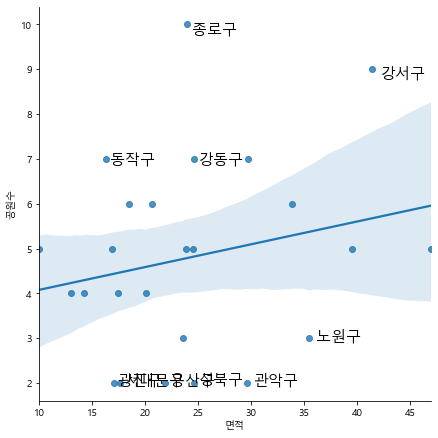

In [1732]:
fp1 = np.polyfit(gu_park_count['면적'],gu_park_count['공원수'],1)
f1 = np.poly1d(fp1)
gu_park_count['오차'] = np.abs(gu_park_count['공원수'] - f1(gu_park_count['면적']))
gu_park_count_sort = gu_park_count.sort_values(by='오차',ascending=False).set_index('지역')
sns.lmplot(data = gu_park_count,x='면적',y='공원수',size=6)
for n in range(10):
    plt.text(gu_park_count_sort['면적'][n]*1.02, gu_park_count_sort['공원수'][n]*0.98,
                gu_park_count_sort.index[n],fontsize=15)
# 면적대비 공원수가 어느정도 비례
plt.show()

### 지역별 공원 면적을 합친뒤 구면적과 비교

In [1698]:
park_area = park2.groupby('지역').sum()[['면적']].rename(columns={'면적':'공원면적'})

In [1699]:
gu_park_area = pd.merge(park_area,gu_area2,on='지역')
gu_park_area['면적'] = gu_park_area['면적'].apply(pd.to_numeric) * 10**6
gu_park_area['면적대비 공원면적 비율'] = gu_park_area['공원면적'] / gu_park_area['면적'] * 100
gu_park_area_sort = gu_park_area.sort_values(by='면적대비 공원면적 비율',ascending=False)
gu_park_area_sort.head()


,지역,공원면적,면적,면적대비 공원면적 비율
24,중랑구,7078975.00,18500000.00,38.26
4,관악구,10431453.08,29570000.00,35.28
8,노원구,12235699.30,35440000.00,34.53
23,중구,2969184.50,9960000.00,29.81
11,동작구,3706739.10,16350000.00,22.67


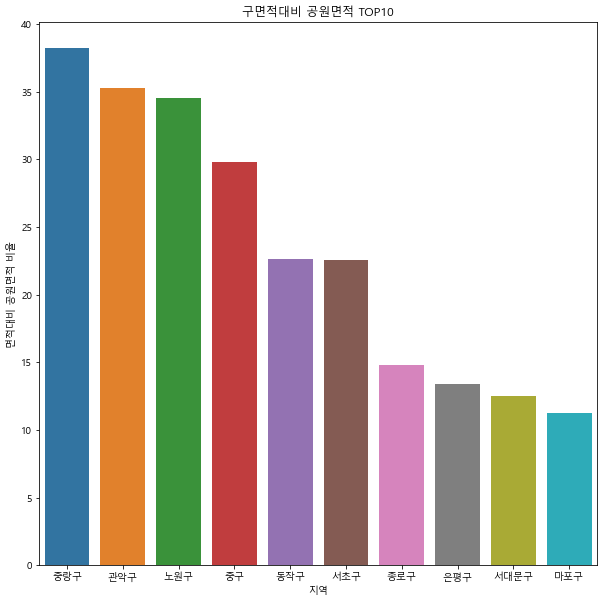

In [1700]:
plt.figure(figsize=(10,10))
sns.barplot(data=gu_park_area_sort.head(10),y='면적대비 공원면적 비율',x='지역')
plt.title("구면적대비 공원면적 TOP10")
plt.show()

### 지금까지 나온 데이터 프레임 합침

In [1701]:
result = pd.merge(gu_park_area,park2_group,on='지역').rename(columns={'공원명':'공원수'})
result.head()

,지역,공원면적,면적,면적대비 공원면적 비율,공원수
0,강남구,2851968.50,39500000.00,7.22,5
1,강동구,1526389.30,24590000.00,6.21,7
2,강북구,2047054.40,23600000.00,8.67,3
3,강서구,2194154.10,41440000.00,5.29,9
4,관악구,10431453.08,29570000.00,35.28,2


### 인구수와 공원면적 비교

In [1702]:
pop = pd.read_csv("./data/02.pop_result.csv").rename(columns={'구별':'지역'})
pop.head()


,지역,인구수,한국인,외국인,고령자,외국인비율,고령자비율,일반가구수,1인,2인,3인,4인,1인 가구 비율,5인이상,인구수대비 1인 오차,고령자와 5인이상 오차,1인가구와 외국인 오차
0,구로구,435751,405579,30172,69312,6.92,15.91,156235,44151,41836,34633,27310,28.26,8305,8594.50,230.20,4.92
1,영등포구,405982,375630,30352,60826,7.48,14.98,149831,53477,37774,29904,22271,35.69,6405,3554.61,934.08,3.72
2,관악구,514555,498574,15981,78206,3.11,15.20,236761,112733,54106,35925,25997,47.61,8000,52514.21,1788.82,3.46
3,금천구,249641,232157,17484,39361,7.00,15.77,96298,34564,24305,18948,14102,35.89,4379,531.97,65.46,3.20
4,중구,135321,125800,9521,24265,7.04,17.93,53102,20803,14101,9601,6463,39.18,2134,3451.56,51.73,2.46


In [1703]:
pop[['지역','인구수']].head()


,지역,인구수
0,구로구,435751
1,영등포구,405982
2,관악구,514555
3,금천구,249641
4,중구,135321


In [1704]:
result = pd.merge(result,pop[['지역','인구수']],on='지역')
result.head()

,지역,공원면적,면적,면적대비 공원면적 비율,공원수,인구수
0,강남구,2851968.50,39500000.00,7.22,5,544085
1,강동구,1526389.30,24590000.00,6.21,7,462275
2,강북구,2047054.40,23600000.00,8.67,3,313550
3,강서구,2194154.10,41440000.00,5.29,9,589536
4,관악구,10431453.08,29570000.00,35.28,2,514555


In [1705]:
result['인구 비율'] = result['인구수'] / result['인구수'].sum()
result['인당 면적비'] = result['공원면적'] / result['인구수']
result.head()

,지역,공원면적,면적,면적대비 공원면적 비율,공원수,인구수,인구 비율,인당 면적비
0,강남구,2851968.50,39500000.00,7.22,5,544085,0.05,5.24
1,강동구,1526389.30,24590000.00,6.21,7,462275,0.05,3.30
2,강북구,2047054.40,23600000.00,8.67,3,313550,0.03,6.53
3,강서구,2194154.10,41440000.00,5.29,9,589536,0.06,3.72
4,관악구,10431453.08,29570000.00,35.28,2,514555,0.05,20.27


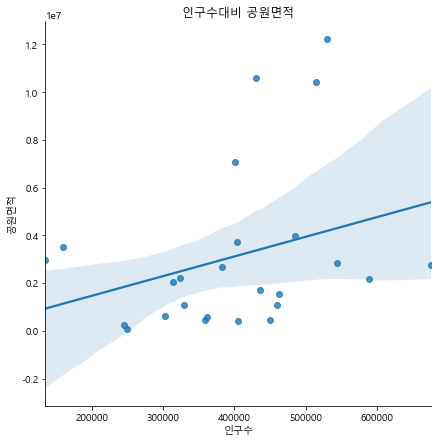

In [1706]:
sns.lmplot(data = result,x='인구수',y='공원면적',size=6)
plt.title("인구수대비 공원면적")
plt.show()

### 공원크기에 따라 지도에 표시하기 + 인당 공원 면적비

In [1707]:
geo_path = './data/02. skorea_municipalities_geo_simple.json'
geo_str = json.load(open(geo_path, encoding='UTF-8'))

In [1708]:
park2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 0 to 131
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   공원명         120 non-null    object 
 1   면적          120 non-null    float64
 2   지역          120 non-null    object 
 3   공원주소        120 non-null    object 
 4   X좌표(WGS84)  119 non-null    float64
 5   Y좌표(WGS84)  119 non-null    float64
 6   구주소         120 non-null    object 
 7   lat         120 non-null    object 
 8   lng         120 non-null    object 
dtypes: float64(3), object(6)
memory usage: 14.4+ KB


In [1709]:
park2.sort_values(by='면적')

,공원명,면적,지역,공원주소,X좌표(WGS84),Y좌표(WGS84),구주소,lat,lng
9,매화근린공원,1980.40,강서구,서울특별시 강서구 등촌동 630-14,126.86,37.56,서울 강서구 등촌동,126.860946982509,37.5574585792214
123,연신내물빛공원,2560.00,은평구,서울특별시 은평구 통일로 849,126.92,37.62,서울 은평구 갈현동,126.920711278292,37.6189939564735
119,문화역 서울284,2964.00,중구,서울특별시 중구 통일로 1 서울역,126.97,37.56,서울 중구 봉래동2가 122-28,126.971588794949,37.5558828120624
95,금천폭포근린공원,4835.00,금천구,서울특별시 금천구 시흥대로38길 61(시흥동 937-2),126.90,37.45,서울 금천구 시흥동 937-2,126.904249455656,37.4466995872729
10,성수근린공원,5197.70,성동구,서울특별시 성동구 성수2가 3동 302-25,127.05,37.54,서울 성동구 성수동2가 302-1,127.052446160552,37.5448499668206
...,...,...,...,...,...,...,...,...,...
116,우면산도시자연공원,4180551.00,서초구,서울특별시 서초구 우면동 산35-1,127.01,37.47,서울 서초구 방배동 산 92-3,127.008433267143,37.4713717502903
72,용마폭포공원,5107964.00,중랑구,서울특별시 중랑구 면목동 산1-4,127.09,37.57,서울 중랑구 면목동 산 1-4,127.090053515636,37.5736051123377
71,불암산도시자연공원,5332422.00,노원구,서울특별시 노원구 한글비석로12길 51-33(불암산공원),127.10,37.66,서울 노원구 중계동 산 101-45,127.081494871112,37.6555053167396
83,수락산도시자연공원,6691885.30,노원구,서울특별시 노원구 상계동 산3-1,127.08,37.70,서울 노원구 상계동 산 3-1,127.065364973013,37.6920670995472


In [1710]:
result2 = result.set_index('지역')

In [1711]:
map = folium.Map(location=[37.5502,126.982],zoom_start=11,title="Your map title")
map.choropleth(geo_data = geo_str,
                data = result2,
                columns=[result2.index, '인당 면적비'],
                fill_color = 'PuRd',
                key_on = 'feature.id')
for n in park2.index:
    folium.CircleMarker([park2['lng'][n],park2['lat'][n]],
                        radius = park2['면적'][n]/500000,
                        popup=park2['공원명'][n],
                        color='#3186cc',fill_color='#3186cc').add_to(map)
title_html = '''
             <h3 align="center" style="font-size:20px"><b>인당면적비와 공원크기</b></h3>
             '''
map.get_root().html.add_child(folium.Element(title_html))
map

In [1712]:
map = folium.Map(location=[37.5502,126.982],zoom_start=11,title="Your map title")
map.choropleth(geo_data = geo_str,
                data = result2,
                columns=[result2.index, '인당 면적비'],
                fill_color = 'PuRd',
                key_on = 'feature.id')
for n in park2.index:
    folium.Marker([park2['lng'][n],park2['lat'][n]],
                    size=100,color='#3186cc',\
                    popup=park2['공원명'][n]).add_to(map)
title_html = '''
             <h3 align="center" style="font-size:20px"><b>인당면적비와 공원위치</b></h3>
             '''
map.get_root().html.add_child(folium.Element(title_html))
map

In [1713]:
gangseo_park = park2[park2['지역'] == '강서구']
gangseo_park_lng_maen = gangseo_park['lng'].apply(pd.to_numeric).mean() 
gangseo_park_lat_maen = gangseo_park['lat'].apply(pd.to_numeric).mean() 
gangseo_park


,공원명,면적,지역,공원주소,X좌표(WGS84),Y좌표(WGS84),구주소,lat,lng
9,매화근린공원,1980.40,강서구,서울특별시 강서구 등촌동 630-14,126.86,37.56,서울 강서구 등촌동,126.860946982509,37.5574585792214
33,허준공원,29843.80,강서구,서울특별시 강서구 허준로5길 42,126.85,37.57,서울 강서구 가양동 1471,126.852288177516,37.5681915373236
35,궁산근린공원,135002.70,강서구,서울특별시 강서구 가양동 산4-7,126.84,37.57,서울 강서구 가양동 산 8-1,126.839068805614,37.5738000661701
37,꿩고개근린공원,180000.00,강서구,서울특별시 강서구 방화동 산110,126.82,37.58,서울 강서구 방화동,126.815597825426,37.5801808080392
53,방화근린공원,72132.00,강서구,서울특별시 강서구 금낭화로 176(방화공원),126.81,37.58,서울 강서구 방화동 산 133-2,126.814941354822,37.5819493300111
57,염창근린공원,112070.00,강서구,서울특별시 강서구 염창동 산24-1,126.87,37.56,서울 강서구 염창동 233-1,126.862870399937,37.5627154390156
76,우장산근린공원,359435.20,강서구,서울특별시 강서구 내발산동 산4-5,126.84,37.55,서울 강서구 내발산동 산 60-1,126.845438948235,37.5544696115285
88,봉제산공원,917190.00,강서구,서울특별시 강서구 화곡동 산41-6,126.85,37.54,서울 강서구 화곡동 산 41-6,126.851960042338,37.542327469887
112,개화근린공원,386500.00,강서구,서울특별시 강서구 개화동 산17,126.81,37.58,서울 강서구 개화동 산 17,126.805797363476,37.5880427342845


In [1714]:
map = folium.Map(location=[gangseo_park_lng_maen,gangseo_park_lat_maen],zoom_start=14,title="Your map title")
# map.choropleth(geo_data = geo_str,
#                 data = result2,
#                 columns=[result2.index, '인당 면적비'],
#                 fill_color = 'PuRd',
#                 key_on = 'feature.id')
for n in gangseo_park.index:
    folium.Marker([gangseo_park['lng'][n],gangseo_park['lat'][n]],
                    size=100,color='#3186cc',\
                    popup=gangseo_park['공원명'][n]).add_to(map)
title_html = '''
             <h3 align="center" style="font-size:20px"><b>강서구 공원위치</b></h3>
             '''
map.get_root().html.add_child(folium.Element(title_html))
map

### 구별 공원대지와 통합대기환경지수의 상관관계

In [1715]:
air_condition = pd.read_csv("./data/서울시 실시간 자치구별 대기환경 현황.csv",encoding='euc-kr')
#서초구는 점검중이라 데이터가 없습니다.
air_condition = air_condition.set_index('측정소명').drop(['서초구'])[['통합대기환경지수','미세먼지 농도(단위:㎍/㎥)']]
air_condition.head()

,통합대기환경지수,미세먼지 농도(단위:㎍/㎥)
측정소명,,
종로구,71,27
중구,70,30
용산구,67,31
성동구,68,28
광진구,69,25


In [1716]:
result2.head()

,공원면적,면적,면적대비 공원면적 비율,공원수,인구수,인구 비율,인당 면적비
지역,,,,,,,
강남구,2851968.50,39500000.00,7.22,5,544085,0.05,5.24
강동구,1526389.30,24590000.00,6.21,7,462275,0.05,3.30
강북구,2047054.40,23600000.00,8.67,3,313550,0.03,6.53
강서구,2194154.10,41440000.00,5.29,9,589536,0.06,3.72
관악구,10431453.08,29570000.00,35.28,2,514555,0.05,20.27


In [1717]:
air_merge = pd.merge(result2,air_condition,left_index=True, right_index=True)
air_merge.head()

,공원면적,면적,면적대비 공원면적 비율,공원수,인구수,인구 비율,인당 면적비,통합대기환경지수,미세먼지 농도(단위:㎍/㎥)
강남구,2851968.50,39500000.00,7.22,5,544085,0.05,5.24,62,22
강동구,1526389.30,24590000.00,6.21,7,462275,0.05,3.30,71,26
강북구,2047054.40,23600000.00,8.67,3,313550,0.03,6.53,63,30
강서구,2194154.10,41440000.00,5.29,9,589536,0.06,3.72,64,28
관악구,10431453.08,29570000.00,35.28,2,514555,0.05,20.27,58,27


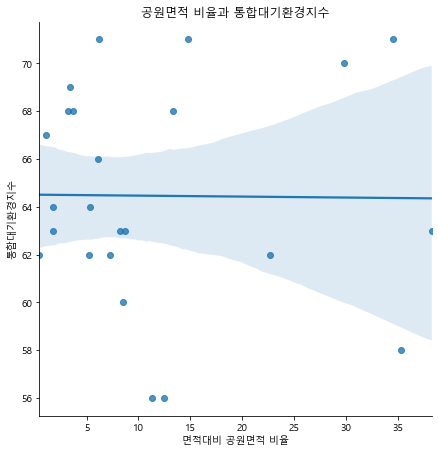

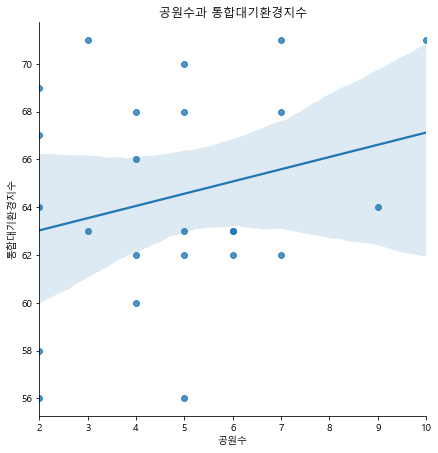

In [1718]:
sns.lmplot(data = air_merge,x='면적대비 공원면적 비율',y='통합대기환경지수',size=6)
plt.title("공원면적 비율과 통합대기환경지수")
sns.lmplot(data = air_merge,x='공원수',y='통합대기환경지수',size=6)
plt.title("공원수과 통합대기환경지수")
plt.show()

#### 공원면적 비율과 통합대기환경지수는 큰 상관관계가 없어보이지만 
#### 공원수와 통합대기환경지수는 어느정도 관계가 있어보임

In [1733]:
help(sns.lmplot)


Help on function lmplot in module seaborn.regression:

lmplot(*, x=None, y=None, data=None, hue=None, col=None, row=None, palette=None, col_wrap=None, height=5, aspect=1, markers='o', sharex=True, sharey=True, hue_order=None, col_order=None, row_order=None, legend=True, legend_out=True, x_estimator=None, x_bins=None, x_ci='ci', scatter=True, fit_reg=True, ci=95, n_boot=1000, units=None, seed=None, order=1, logistic=False, lowess=False, robust=False, logx=False, x_partial=None, y_partial=None, truncate=True, x_jitter=None, y_jitter=None, scatter_kws=None, line_kws=None, size=None)
    Plot data and regression model fits across a FacetGrid.
    
    This function combines :func:`regplot` and :class:`FacetGrid`. It is
    intended as a convenient interface to fit regression models across
    conditional subsets of a dataset.
    
    When thinking about how to assign variables to different facets, a general
    rule is that it makes sense to use ``hue`` for the most important
    comparis